In [38]:
import json
import numpy as np
import pandas as pd
from pandas import DataFrame
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [39]:
'''
5 pieces of data that we want to predict the next hour:
1. Number of tweets in that hour
2. Total number of retweets
3. Time of day
4. Sum of number of followers of all users
5. Max number of followers of users

To obtain 1 and 3 we need to get the time stamp data
To get 2, we need to create a retweeded? list
To get 4 and 5 we need to get the number of followers of each of the users who is tweeting
'''
def get_data_and_do_everything(hashtag):
    dictionary = {'#GoHawks' : ['tweets_#gohawks.txt', 188136],
                    '#GoPatriots' : ['tweets_#gopatriots.txt', 26232],
                    '#NFL' : ['tweets_#nfl.txt', 259024],
                    '#Patriots' : ['tweets_#patriots.txt', 489713],
                    '#SB49' : ['tweets_#sb49.txt', 826951],
                    '#SuperBowl' : ['tweets_#superbowl.txt', 1348767]}
    
    time_stamp = np.zeros(dictionary[hashtag][1])
    followers_by_user = np.zeros(dictionary[hashtag][1])
    retweeted = [False] * dictionary[hashtag][1]
    
    file = open('./tweet_data/'+dictionary[hashtag][0])
    for (line, index) in zip(file, range(0, dictionary[hashtag][1])):
        data = json.loads(line)
        time_stamp[index] = data['citation_date']
        followers_by_user[index] = data['author']['followers']
        author_name = data['author']['nick']
        original_author_name = data['original_author']['nick']
        if original_author_name != author_name:
            retweeted[index] = True
    file.close()
    calculations(time_stamp, followers_by_user, retweeted, dictionary, hashtag)

In [40]:
def calculations(time_stamp, followers_by_user, retweeted, dictionary, hashtag):
    hour = int((max(time_stamp)-min(time_stamp))/3600)+1
    hourly_tweet_number = [0]*(hour)
    hourly_retweet_number = [0]*(hour)
    hourly_sum_of_followers = [0]*(hour)
    hourly_max_follower = [0]*(hour)
    time_of_day = [0]*(hour)
    
    start = min(time_stamp)
    for i in range(0, dictionary[hashtag][1]):
        current_hour = int((time_stamp[i] - start)/3600)
        hourly_tweet_number[current_hour] += 1
        if retweeted[i] == True:
            hourly_retweet_number[current_hour] += 1
        hourly_sum_of_followers[current_hour] += followers_by_user[i]
        if followers_by_user[i] > hourly_max_follower[current_hour]:
            hourly_max_follower[current_hour] = followers_by_user[i]
            
        for i in range(0, len(time_of_day)):
            time_of_day[i] = i%24
            
    convert_to_df(hourly_tweet_number, hourly_retweet_number, hourly_sum_of_followers, hourly_max_follower, time_of_day, hashtag)

In [41]:
def convert_to_df(hourly_tweet_number, hourly_retweet_number, hourly_sum_of_followers, hourly_max_follower, time_of_day, hashtag):
    target_value = hourly_tweet_number[1:]
    target_value.append(0)
    full_data = np.array([hourly_tweet_number, hourly_retweet_number, hourly_sum_of_followers, hourly_max_follower, time_of_day, target_value])
    full_data = np.transpose(full_data)
    data_frame = DataFrame(full_data)
    data_frame.columns = ['hourly_tweet_number', 'hourly_retweet_number', 'hourly_sum_of_followers', 'hourly_max_follower', 'time_of_day', 'target_value']
    linear_regression(data_frame, hashtag)
    

In [42]:
def one_hot(df, cols):
    """
    @param df pandas DataFrame
    @param cols a list of columns to encode 
    @return a DataFrame with one-hot encoding
    """
    for each in cols:
        dummies = pd.get_dummies(df[each], prefix=each, drop_first=False)
        df = pd.concat([df, dummies], axis=1)
    return df

In [43]:
def calculate_RMSE(predicted, actual):  
    return np.sqrt(np.mean((predicted - actual) ** 2))  

In [44]:
def linear_regression(data_frame, hashtag):
    #need to one hot encode time of day
    training_data = one_hot(data_frame, ['time_of_day'])
    training_data.drop('time_of_day', 1, inplace=True)
    target_data = training_data.pop('target_value')
    linear_reg = LinearRegression(fit_intercept = False)
    linear_regression_fitted = linear_reg.fit(training_data, target_data)
    
    predicted = linear_regression_fitted.predict(training_data)
    RMSE = calculate_RMSE(predicted, target_data)
    print('RMSE is:', RMSE)
    plot(target_data, predicted, hashtag)
    perform_t_test(target_data, training_data)

In [45]:
def plot(target_data, predicted, hashtag):
    plt.scatter(target_data, predicted)
    plt.plot([target_data.min(), target_data.max()], [target_data.min(), target_data.max()])
    plt.xlabel('Actual Value')
    plt.ylabel('Predicted Value')
    plt.title('Predicted Value VS Actual Value ' + str(hashtag))
    plt.show()

In [46]:
def perform_t_test(target_data, training_data):
    model = sm.OLS(target_data, training_data)
    results = model.fit()
    print(results.summary())

RMSE is: 910.992199681


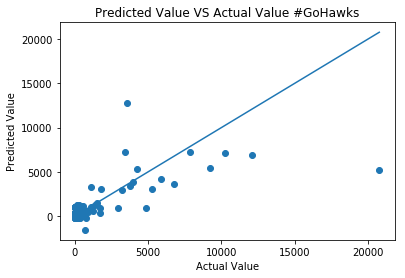

                            OLS Regression Results                            
Dep. Variable:           target_value   R-squared:                       0.532
Model:                            OLS   Adj. R-squared:                  0.509
Method:                 Least Squares   F-statistic:                     23.19
Date:                Sun, 11 Mar 2018   Prob (F-statistic):           1.44e-73
Time:                        23:26:10   Log-Likelihood:                -4767.2
No. Observations:                 579   AIC:                             9590.
Df Residuals:                     551   BIC:                             9712.
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
hourly_tweet_number       

In [47]:
get_data_and_do_everything('#GoHawks')

RMSE is: 188.211600425


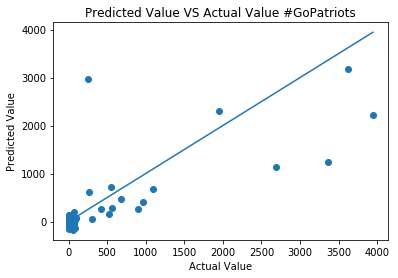

                            OLS Regression Results                            
Dep. Variable:           target_value   R-squared:                       0.627
Model:                            OLS   Adj. R-squared:                  0.608
Method:                 Least Squares   F-statistic:                     34.00
Date:                Sun, 11 Mar 2018   Prob (F-statistic):           6.50e-99
Time:                        23:26:13   Log-Likelihood:                -3827.5
No. Observations:                 575   AIC:                             7711.
Df Residuals:                     547   BIC:                             7833.
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
hourly_tweet_number       

In [48]:
get_data_and_do_everything('#GoPatriots')

RMSE is: 567.105281403


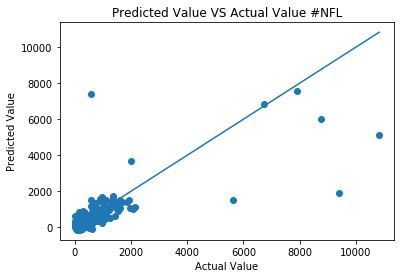

                            OLS Regression Results                            
Dep. Variable:           target_value   R-squared:                       0.585
Model:                            OLS   Adj. R-squared:                  0.565
Method:                 Least Squares   F-statistic:                     29.17
Date:                Sun, 11 Mar 2018   Prob (F-statistic):           7.38e-89
Time:                        23:26:42   Log-Likelihood:                -4554.8
No. Observations:                 587   AIC:                             9166.
Df Residuals:                     559   BIC:                             9288.
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
hourly_tweet_number       

In [49]:
get_data_and_do_everything('#NFL')

RMSE is: 2302.1183222


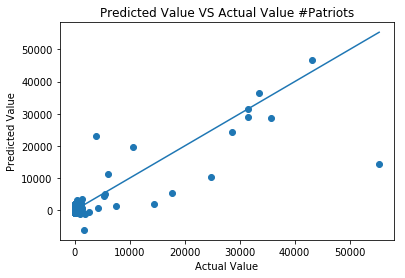

                            OLS Regression Results                            
Dep. Variable:           target_value   R-squared:                       0.723
Model:                            OLS   Adj. R-squared:                  0.709
Method:                 Least Squares   F-statistic:                     53.98
Date:                Sun, 11 Mar 2018   Prob (F-statistic):          9.92e-137
Time:                        23:27:37   Log-Likelihood:                -5377.2
No. Observations:                 587   AIC:                         1.081e+04
Df Residuals:                     559   BIC:                         1.093e+04
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
hourly_tweet_number       

In [50]:
get_data_and_do_everything('#Patriots')

RMSE is: 3799.84333229


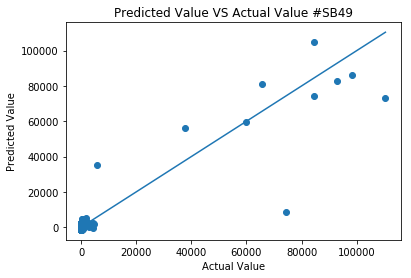

                            OLS Regression Results                            
Dep. Variable:           target_value   R-squared:                       0.857
Model:                            OLS   Adj. R-squared:                  0.850
Method:                 Least Squares   F-statistic:                     122.7
Date:                Sun, 11 Mar 2018   Prob (F-statistic):          3.81e-214
Time:                        23:29:45   Log-Likelihood:                -5632.7
No. Observations:                 583   AIC:                         1.132e+04
Df Residuals:                     555   BIC:                         1.144e+04
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
hourly_tweet_number       

In [51]:
get_data_and_do_everything('#SB49')

RMSE is: 6433.3724713


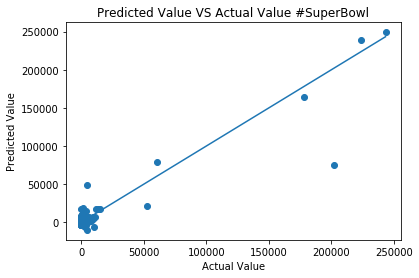

                            OLS Regression Results                            
Dep. Variable:           target_value   R-squared:                       0.870
Model:                            OLS   Adj. R-squared:                  0.864
Method:                 Least Squares   F-statistic:                     138.6
Date:                Mon, 12 Mar 2018   Prob (F-statistic):          1.86e-227
Time:                        00:19:13   Log-Likelihood:                -5970.3
No. Observations:                 586   AIC:                         1.200e+04
Df Residuals:                     558   BIC:                         1.212e+04
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
hourly_tweet_number       

In [52]:
get_data_and_do_everything('#SuperBowl')